In [3]:
import os, sys
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [28]:
# GRADIENT CHECKING
import numpy as np
from lib.layers import Dense
from lib.activations import Tanh
from lib.losses import mse_loss, mse_loss_prime

def gradient_check(layer, input_data, target, epsilon=1e-4):
    """
    Verifies backpropagation by comparing Analytical Gradients (from code)
    vs Numerical Gradients (from finite difference formula).
    Formula: dL/dW approx [L(W + e) - L(W - e)] / (2 * e)
    """
    print(f"--- Gradient Check for {layer.__class__.__name__} Layer ---")
    
    # 1. Analytical Gradients 
    output = layer.forward(input_data)
    grad_output = mse_loss_prime(target, output)
    
    # We pass learning_rate=None because we only want to calculate gradients, not update
    layer.backward(grad_output, learning_rate=None) 
    
    # Get the gradients from the lib
    analytical_grad = layer.grad_weights.copy()
    
    # 2. Numerical Gradients (The "Brute Force" Check)
    numerical_grad = np.zeros_like(layer.weights)
    original_weights = layer.weights.copy()
    
    # Iterate over every single weight to perturb it
    it = np.nditer(layer.weights, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        
        # Calculate L(W + epsilon)
        layer.weights[idx] = original_weights[idx] + epsilon
        out_plus = layer.forward(input_data)
        loss_plus = mse_loss(target, out_plus)
        
        # Calculate L(W - epsilon)
        layer.weights[idx] = original_weights[idx] - epsilon
        out_minus = layer.forward(input_data)
        loss_minus = mse_loss(target, out_minus)
        
        # Central Difference Formula
        numerical_grad[idx] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # Reset weight to original so we don't break the layer
        layer.weights[idx] = original_weights[idx]
        it.iternext()
        
    # 3. Compare Results
    numerator = np.linalg.norm(analytical_grad - numerical_grad)
    denominator = np.linalg.norm(analytical_grad) + np.linalg.norm(numerical_grad)
    
    # Avoid division by zero
    if denominator == 0:
        relative_error = 0
    else:
        relative_error = numerator / denominator

    print(f"   Analytical Gradient Norm: {np.linalg.norm(analytical_grad):.6f}")
    print(f"   Numerical Gradient Norm:  {np.linalg.norm(numerical_grad):.6f}")
    print(f"   Relative Error:           {relative_error:.2e}")
    
    if relative_error < 1e-5:
        print("   PASS: Backpropagation is correct.")
    else:
        print("   FAIL: Gradients diverge significantly.")
    print("-------------------------------------------------------")

# --- Run the Test ---
# Create random dummy data for testing
print("Generating random data for testing...")
test_input = np.random.randn(2).reshape(2,)   
test_target = np.random.randn(1).reshape(1,)

# Test a Dense Layer
test_layer = Dense(2, 1)
gradient_check(test_layer, test_input, test_target)

Generating random data for testing...
--- Gradient Check for Dense Layer ---
   Analytical Gradient Norm: 0.455828
   Numerical Gradient Norm:  0.455828
   Relative Error:           2.40e-13
   PASS: Backpropagation is correct.
-------------------------------------------------------


In [29]:
import numpy as np

# XOR dataset: 4 samples, 2 features, 1 output
x_train = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])

y_train = np.array([
    [-1],
    [1],
    [1],
    [-1]
])

print("XOR inputs:")
print(x_train)
print("XOR labels:")
print(y_train)

XOR inputs:
[[-1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]]
XOR labels:
[[-1]
 [ 1]
 [ 1]
 [-1]]


In [30]:
from lib.network import Network
from lib.layers import Dense
from lib.activations import Tanh, Sigmoid
from lib.losses import mse_loss, mse_loss_prime
from lib.optimizer import SGD

# Create the network
net = Network()
net.add(Dense(2, 4))   # input 2 → hidden 4
net.add(Tanh())        # activation
net.add(Dense(4, 1))   # hidden 4 → output 1
net.add(Tanh())        # activation

# Set loss
net.use_loss(mse_loss, mse_loss_prime)

# Create optimizer
optimizer = SGD(learning_rate=0.1)

In [31]:
# Training the network
net.train(x_train, y_train, epochs=10000, learning_rate=0.1)

Epoch 1000/10000   error=0.000425
Epoch 2000/10000   error=0.000199
Epoch 3000/10000   error=0.000128
Epoch 4000/10000   error=0.000094
Epoch 5000/10000   error=0.000074
Epoch 6000/10000   error=0.000061
Epoch 7000/10000   error=0.000052
Epoch 8000/10000   error=0.000045
Epoch 9000/10000   error=0.000040
Epoch 10000/10000   error=0.000036


In [32]:
# Final predictions
print("XOR Predictions after training:")
for x, y_true in zip(x_train, y_train):
    pred = x
    for layer in net.layers:
        pred = layer.forward(pred)
    print(f"Input: {x}  Predicted: {pred[0]:.4f}  True: {y_true[0]}")

XOR Predictions after training:
Input: [-1 -1]  Predicted: -0.9936  True: -1
Input: [-1  1]  Predicted: 0.9961  True: 1
Input: [ 1 -1]  Predicted: 0.9938  True: 1
Input: [1 1]  Predicted: -0.9930  True: -1


Training for Loss Curve...
Training Complete.


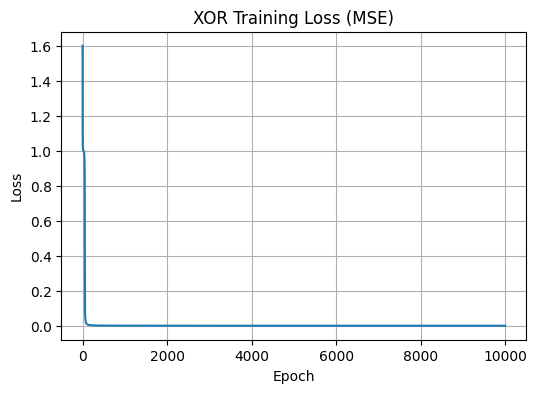

In [7]:
import matplotlib.pyplot as plt
from lib.optimizer import SGD 

# --- Reset Network for fresh training ---
net = Network()
net.add(Dense(2, 4))
net.add(Tanh())
net.add(Dense(4, 1))
net.add(Tanh())
net.use_loss(mse_loss, mse_loss_prime)
# -----------------------------------------------------------------------------------

# Setup for the manual loop
loss_history = []
epochs = 10000
learning_rate = 0.1  
optimizer = SGD(learning_rate=learning_rate)

print("Training for Loss Curve...")

for epoch in range(epochs):
    total_loss = 0
    for x, y in zip(x_train, y_train):
        # 1. Forward
        output = x
        for layer in net.layers:
            output = layer.forward(output)
            
        # 2. Loss
        total_loss += mse_loss(y, output)
        
        # 3. Backward (Calculate Gradients)
        grad = mse_loss_prime(y, output)
        for layer in reversed(net.layers):
            grad = layer.backward(grad, learning_rate=None) 
            
        # 4. Optimizer Step (Update Weights) 
        for layer in net.layers:
            optimizer.update(layer)
            
    loss_history.append(total_loss / 4)

print("Training Complete.")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.title("XOR Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

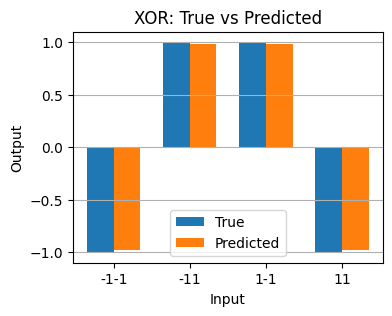

In [8]:
labels = ['-1-1', '-11', '1-1', '11']
true_vals = [-1, 1, 1, -1]
pred_vals = [-0.98, 0.98, 0.98, -0.98]  

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(4, 3))
plt.bar(x - width/2, true_vals, width, label='True', color='tab:blue')
plt.bar(x + width/2, pred_vals, width, label='Predicted', color='tab:orange')
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("XOR: True vs Predicted")
plt.xticks(x, labels)
plt.legend()
plt.ylim(-1.1, 1.1)
plt.grid(axis='y')
plt.show()

In [9]:
# Convert predictions to binary labels
predictions = []
for x in x_train:
    pred = x
    for layer in net.layers:
        pred = layer.forward(pred)
    label = 1 if pred[0] >= 0 else -1
    predictions.append(label)

# Accuracy
correct = np.sum(np.array(predictions) == y_train.flatten())
accuracy = correct / len(y_train) * 100

print("Predicted labels:", predictions)
print("True labels:     ", y_train.flatten().tolist())
print(f"XOR Accuracy: {accuracy:.1f}%")

Predicted labels: [-1, 1, 1, -1]
True labels:      [-1, 1, 1, -1]
XOR Accuracy: 100.0%


In [39]:
# Comparison (Our Lib vs TensorFlow)

import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from lib.network import Network
from lib.layers import Dense
from lib.activations import Tanh
from lib.losses import mse_loss, mse_loss_prime
from lib.optimizer import SGD

print("STARTING BENCHMARK: Custom Lib vs TensorFlow ⚡")

# Constants for fair comparison
EPOCHS = 10000
LR = 0.1

# 1. CUSTOM LIBRARY TRAINING
print(f"\n1. Training Custom Model ({EPOCHS} epochs)...")
net = Network()
net.add(Dense(2, 4))
net.add(Tanh())
net.add(Dense(4, 1))
net.add(Tanh())
net.use_loss(mse_loss, mse_loss_prime)
custom_optimizer = SGD(learning_rate=LR)

custom_loss_history = []
start_time_custom = time.time()

for i in range(EPOCHS):
    epoch_loss = 0
    for j in range(len(x_train)):
        # Forward
        output = x_train[j]
        for layer in net.layers:
            output = layer.forward(output)
        epoch_loss += mse_loss(y_train[j], output)
        
        # Backward
        grad = mse_loss_prime(y_train[j], output)
        for layer in reversed(net.layers):
            grad = layer.backward(grad, learning_rate=None)
        
        # Update
        for layer in net.layers:
            custom_optimizer.update(layer)
            
    custom_loss_history.append(epoch_loss / len(x_train))

end_time_custom = time.time()
time_custom = end_time_custom - start_time_custom
final_loss_custom = custom_loss_history[-1]

# 2. TENSORFLOW/KERAS TRAINING (For comparison)
print(f"2. Training Keras Model ({EPOCHS} epochs)...")
model = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])
# We use SGD to match your optimizer exactly
keras_optimizer = keras.optimizers.SGD(learning_rate=LR)
model.compile(optimizer=keras_optimizer, loss='mse')

start_time_keras = time.time()
# batch_size=1 is crucial to match your "Update every sample" logic
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=1, verbose=0)
end_time_keras = time.time()

time_keras = end_time_keras - start_time_keras
keras_loss_history = history.history['loss']
final_loss_keras = keras_loss_history[-1]

# 3. VISUALIZATION & REPORT
print("\n--- BENCHMARK RESULTS ---")
print(f"{'Metric':<20} | {'My Library':<15} | {'TensorFlow':<15}")
print("-" * 60)
print(f"{'Time Taken (s)':<20} | {time_custom:<15.4f} | {time_keras:<15.4f}")
print(f"{'Final Loss (MSE)':<20} | {final_loss_custom:<15.6f} | {final_loss_keras:<15.6f}")

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Loss Curves Overlay
plt.subplot(1, 2, 1)
plt.plot(custom_loss_history, label='My Library', color='blue', linewidth=2)
plt.plot(keras_loss_history, label='TensorFlow', color='orange', linestyle='--', linewidth=2)
plt.title("Learning Speed Comparison (Loss Curves)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') # Log scale makes it easier to see small differences near 0

# Plot 2: Time Comparison Bar Chart
plt.subplot(1, 2, 2)
bars = plt.bar(['My Library', 'TensorFlow'], [time_custom, time_keras], color=['blue', 'orange'])
plt.title("Training Time (Lower is Better)")
plt.ylabel("Seconds")
plt.grid(axis='y', alpha=0.3)
# Add text on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}s", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

STARTING BENCHMARK: Custom Lib vs TensorFlow ⚡

1. Training Custom Model (10000 epochs)...
2. Training Keras Model (10000 epochs)...


In [20]:
#Milestone_2 Autoencoder & Latent Space Classification
#Data Loading
import numpy as np
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# --- Preprocessing ---
# 1. Convert to float32 for calculations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 2. Normalize pixels from [0, 255] to [0, 1]
x_train = (x_train / 255.0) 
x_test = (x_test / 255.0) 

# 3. Flatten images from (28, 28) to (784,)
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Data range: {x_train.min()} to {x_train.max()}")



2025-12-16 06:34:41.840637: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 06:34:41.841005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 06:34:41.893810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 06:34:43.144071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Data range: 0.0 to 1.0


In [21]:
#Network
from lib.network import Network
from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.losses import mse_loss, mse_loss_prime

# Build the Autoencoder
autoencoder = Network()

# Encoder
autoencoder.add(Dense(784, 128))
autoencoder.add(ReLU())
autoencoder.add(Dense(128, 64))
autoencoder.add(ReLU())

# Decoder
autoencoder.add(Dense(64, 128))
autoencoder.add(ReLU())
autoencoder.add(Dense(128, 784))
autoencoder.add(Sigmoid())

# Set the loss function
autoencoder.use_loss(mse_loss, mse_loss_prime)

In [22]:
# Training the autoencoder
# NOTE: We use x_train as both the input and the target output
# We'll use a subset of data for a faster training demonstration
num_samples_to_train = 20000
epochs = 30

print(f"Training on {num_samples_to_train} samples for {epochs} epochs...")

autoencoder.train(
    x_train=x_train[:num_samples_to_train],
    y_train=x_train[:num_samples_to_train], # Input is the target
    epochs=epochs,
    learning_rate=0.01
)

print("Training complete.")

Training on 20000 samples for 30 epochs...
Training complete.


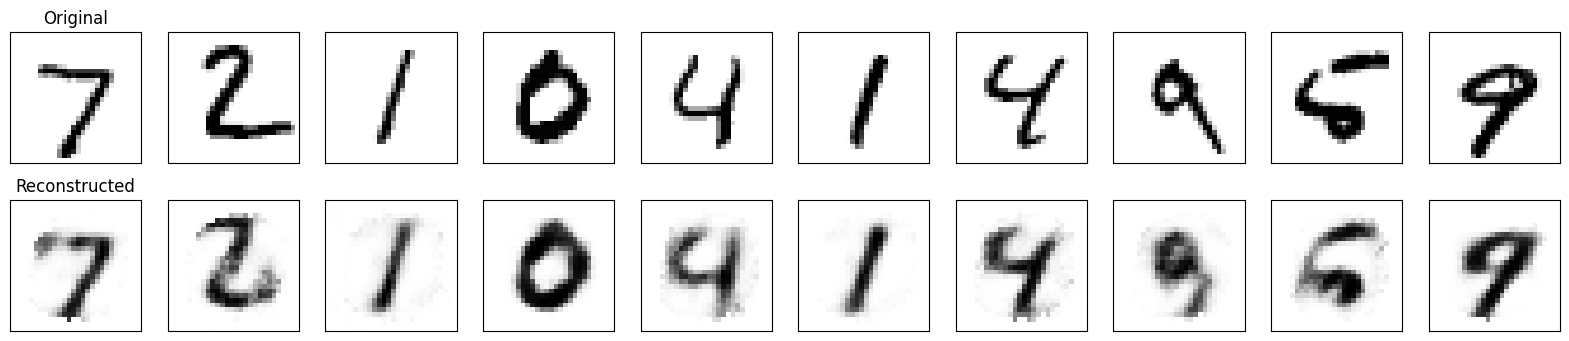

In [24]:
#Visualize Output Image
import matplotlib.pyplot as plt

# Select a few images from the test set to visualize
n_images_to_show = 10
test_images = x_test[:n_images_to_show]

# Get the reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(test_images)

# Plot the original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(n_images_to_show):
    # Display original image
    ax = plt.subplot(2, n_images_to_show, i + 1)
    # We use cmap='gray_r' because the background is -1 (black)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Original")

    # Display reconstructed image
    ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Reconstructed")

plt.show()

In [ ]:
#SVM on Latent Space
# Create a new network for the encoder only
encoder_net = Network()
encoder_net.add(autoencoder.layers[0]) # Dense(784, 128)
encoder_net.add(autoencoder.layers[1]) # ReLU()
encoder_net.add(autoencoder.layers[2]) # Dense(128, 64)
encoder_net.add(autoencoder.layers[3]) # ReLU()

# Use the encoder to transform the full dataset into the latent space
print("Encoding the full dataset...")
x_train_encoded = encoder_net.predict(x_train)
x_test_encoded = encoder_net.predict(x_test)
print("Dataset encoding complete.")

# Convert the list of arrays to a single 2D numpy array for scikit-learn
x_train_encoded = np.array(x_train_encoded)
x_test_encoded = np.array(x_test_encoded)

print(f"\nOriginal test data shape: {x_test.shape}")
print(f"Encoded test data shape: {x_test_encoded.shape}")

Encoding the full dataset...
Dataset encoding complete.

Original test data shape: (10000, 784)
Encoded test data shape: (10000, 64)


Training SVM classifier...
SVM training complete.
Making predictions on test data...

SVM Classification Accuracy on Latent Features: 90.27%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.97      0.99      0.98      1135
           2       0.89      0.90      0.90      1032
           3       0.90      0.88      0.89      1010
           4       0.89      0.90      0.89       982
           5       0.85      0.87      0.86       892
           6       0.92      0.92      0.92       958
           7       0.93      0.89      0.91      1028
           8       0.90      0.83      0.86       974
           9       0.85      0.87      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Confusion Matrix:


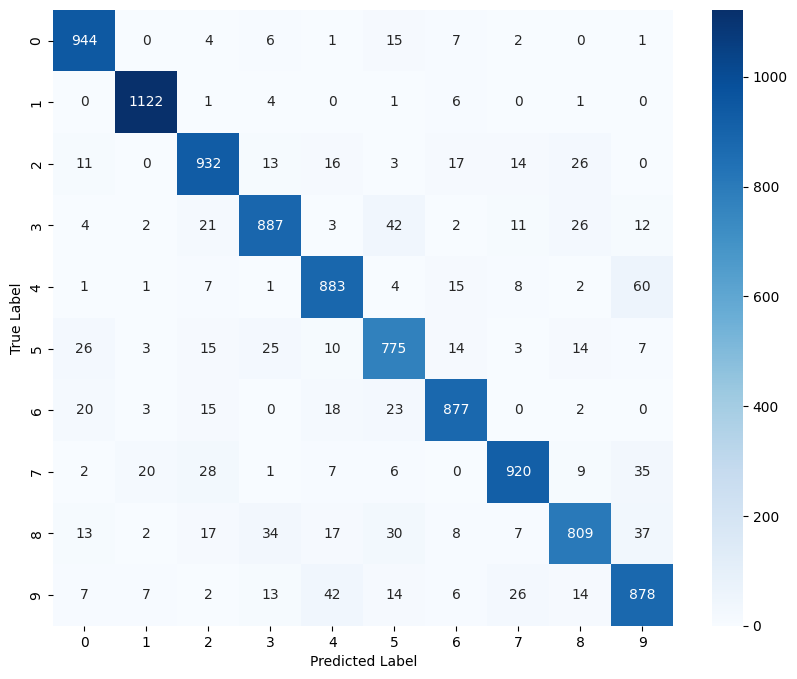

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Train an SVM classifier on the encoded training data
print("Training SVM classifier...")
# We use a subset for faster SVM training as well
num_svm_samples = 10000
svm_classifier = SVC(kernel='rbf') # RBF is a good default kernel
svm_classifier.fit(x_train_encoded[:num_svm_samples], y_train[:num_svm_samples])
print("SVM training complete.")

# Make predictions on the encoded test data
print("Making predictions on test data...")
y_pred_svm = svm_classifier.predict(x_test_encoded)

# Evaluate the results
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Classification Accuracy on Latent Features: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

STARTING AUTOENCODER BENCHMARK: Custom Lib vs. TensorFlow ⚡

1. Training Custom Model (2000 samples, 30 epochs)...
   Epoch 10/30   error=0.068954
   Epoch 20/30   error=0.067359
   Epoch 30/30   error=0.065435
Custom model training complete.

2. Training Keras Model...
Keras model training complete.

--- AUTOENCODER BENCHMARK RESULTS ---
Metric                    | My Library      | TensorFlow/Keras
-----------------------------------------------------------------
Training Time (s)         | 40.4001         | 65.6981        
Final Reconstruction Loss | 0.065435        | 0.064202       


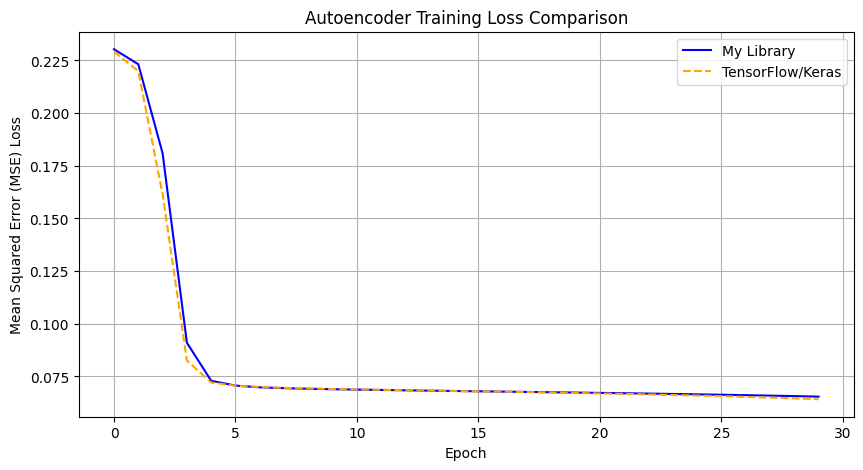

In [ ]:
# --- Baseline Comparison: Autoencoder (Custom Lib vs. TensorFlow/Keras) ---
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from lib.optimizer import SGD 

print("STARTING AUTOENCODER BENCHMARK: Custom Lib vs. TensorFlow ⚡")

# --- 1. Train Custom Library Model (Capturing metrics) ---
# We create a new instance and train it to get a clean performance measure.
autoencoder_custom = Network()
autoencoder_custom.add(Dense(784, 128))
autoencoder_custom.add(ReLU())
autoencoder_custom.add(Dense(128, 64))
autoencoder_custom.add(ReLU())
autoencoder_custom.add(Dense(64, 128))
autoencoder_custom.add(ReLU())
autoencoder_custom.add(Dense(128, 784))
autoencoder_custom.add(Sigmoid())
autoencoder_custom.use_loss(mse_loss, mse_loss_prime)

# Use the same training parameters as before
num_samples_to_train = 2000
epochs = 30
lr = 0.01

# Instantiate the optimizer
optimizer = SGD(learning_rate=lr)

print(f"\n1. Training Custom Model ({num_samples_to_train} samples, {epochs} epochs)...")
start_time_custom = time.time()
# We need to capture the loss history for plotting
custom_loss_history = []
for i in range(epochs):
    epoch_loss = 0
    for j in range(num_samples_to_train):
        # Forward Pass
        output = x_train[j]
        for layer in autoencoder_custom.layers:
            output = layer.forward(output)
        epoch_loss += autoencoder_custom.loss(x_train[j], output)
        
        # Backward Pass (calculates the gradients for each layer)
        grad = autoencoder_custom.loss_prime(x_train[j], output)
        for layer in reversed(autoencoder_custom.layers):
            grad = layer.backward(grad, learning_rate=None) # lr is not used in backward pass
            
        for layer in autoencoder_custom.layers:
            optimizer.update(layer)
            
    custom_loss_history.append(epoch_loss / num_samples_to_train)
    if (i + 1) % 10 == 0:
        print(f"   Epoch {i + 1}/{epochs}   error={custom_loss_history[-1]:.6f}")

end_time_custom = time.time()
time_custom = end_time_custom - start_time_custom
final_loss_custom = custom_loss_history[-1]
print("Custom model training complete.")


# --- 2. Train the TensorFlow/Keras Model ---
print(f"\n2. Training Keras Model...")
autoencoder_keras = keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(784, activation='sigmoid')
])

autoencoder_keras.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), loss='mse')

start_time_keras = time.time()
history = autoencoder_keras.fit(
    x_train[:num_samples_to_train],
    x_train[:num_samples_to_train],
    epochs=epochs,
    batch_size=1, 
    verbose=0
)
end_time_keras = time.time()
time_keras = end_time_keras - start_time_keras
keras_loss_history = history.history['loss']
final_loss_keras = keras_loss_history[-1]
print("Keras model training complete.")

# --- 3. Compare Results ---
print("\n--- AUTOENCODER BENCHMARK RESULTS ---")
print(f"{'Metric':<25} | {'My Library':<15} | {'TensorFlow/Keras':<15}")
print("-" * 65)
print(f"{'Training Time (s)':<25} | {time_custom:<15.4f} | {time_keras:<15.4f}")
print(f"{'Final Reconstruction Loss':<25} | {final_loss_custom:<15.6f} | {final_loss_keras:<15.6f}")

# Plotting Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(custom_loss_history, label='My Library', color='blue')
plt.plot(keras_loss_history, label='TensorFlow/Keras', color='orange', linestyle='--')
plt.title("Autoencoder Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE) Loss")
plt.legend()
plt.grid(True)
plt.show()